In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [14]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, optimize
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple
import copy

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP = 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [5]:
api = wandb.Api()

In [ ]:
cache = analysis.refresh_cache()
print(cache.keys())

In [ ]:
forgetting_exp_path = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited'
forgetting_exp_pattern = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited/{run_id}'

In [ ]:
if 'forgetting_curves_raw_data' in cache:
    forgetting_curves_raw_data = cache['forgetting_curves_raw_data']

else:
    forgetting_runs = api.runs(forgetting_exp_path)
    print('Loaded runs')
    
    trajectories = [analysis.parse_forgetting_results(current_run=run) for run in forgetting_runs]
    forgetting_curves_raw_data = np.stack(trajectories)
    cache = analysis.refresh_cache(dict(forgetting_curves_raw_data=forgetting_curves_raw_data))


# Evaluating two different forms of decay curves

In both models, we treat time steps $t \in \{0, 30\}$

## Power function decay:
Fit $\alpha, \beta$:
\begin{align*}
mem =& \alpha (1 + t)^{-\beta} \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha (1 + t)^{-\beta}
\end{align*}

Or also with $\gamma$:
\begin{align*}
mem =& \alpha (1 + \beta t)^{-\gamma} \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha (1 + \beta t)^{-\gamma}
\end{align*}

## Exponential decay:
Fit $\alpha, \beta$:
\begin{align*}
mem =& \alpha \exp (-\beta t) \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha \exp (-\beta t) \\
\end{align*}

In [ ]:
EPSILON = 1
BASELINE = 0.5
REMAINDER = 1 - BASELINE

def power_decay(x, alpha, beta):
    return REMAINDER * alpha * np.power(x + EPSILON, -beta)

def three_param_power_decay(x, alpha, beta, gamma):
    return REMAINDER * alpha * np.power((beta * x) + EPSILON, -gamma)

def exponential_decay(x, alpha, beta):
    return REMAINDER * alpha * np.exp(-beta * x)

def extract_x_y(data, baseline=BASELINE):
    x = []
    y = []
    for index in np.ndindex(data.shape):
        val = data[index]
        if not np.isnan(val):
            x.append(index[1])
            y.append(val)

    x = np.array(x)
    y = np.array(y)
    return x, y - baseline

def fit_model(data, model, bounds=(-np.inf, np.inf), baseline=BASELINE):
    """
    data is n_replications * n_timesteps, can contain nans
    baseline is what the guessing rate is - 0.5 for binary classification
    """
    x, y = extract_x_y(data, baseline)
    return optimize.curve_fit(model, x, y, maxfev=2000, bounds=bounds)

    

# Data visualization

Solid black line is the mean, cyan area is two SEMs around the mean, now with the fits

In [ ]:
ylim = (0.45, 1.05)
max_x = 31
num_tasks = 10

total_power_mse = 0
total_three_param_power_mse = 0
total_exp_mse = 0

power_decay_params = np.empty((2, 10, 10))
power_decay_params.fill(np.nan)

three_param_power_decay_params = np.empty((3, 10, 10))
three_param_power_decay_params.fill(np.nan)

exp_decay_params = np.empty((2, 10, 10))
exp_decay_params.fill(np.nan)

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            for sample in range(forgetting_curves_raw_data.shape[0]):
                data = forgetting_curves_raw_data[sample, times_trained, episode_num, :]
                nans = np.isnan(data)
                if not np.any(nans):
                    end = len(data)
                else:
                    end = nans.argmax()
                    
                end = min(max_x, end)
                plt.plot(np.arange(end), data[:end], alpha=0.1)
                
            all_point_data = forgetting_curves_raw_data[:, times_trained, episode_num, :]
            means = np.nanmean(all_point_data, axis=0)
            stds = np.nanstd(all_point_data, axis=0)
            non_nan_counts = np.count_nonzero(~np.isnan(all_point_data), axis=0)
            sems = np.divide(stds, non_nan_counts ** 0.5)
            
            plt.plot(means, linewidth=5, color='black')
            plt.fill_between(np.arange(means.shape[0]), means - 2 * sems, means + 2 * sems,
                             color='gray')
            
            (alpha_power, beta_power), _ = fit_model(all_point_data, power_decay,
                                                     bounds=[(0, 0), (1, 5)])
            power_decay_params[:, times_trained, episode_num] = (alpha_power, beta_power)
            power_preds = BASELINE + power_decay(np.arange(means.shape[0]), alpha_power, beta_power)
            power_mse = ((power_preds - means) ** 2).mean()
            total_power_mse += power_mse
            
            (alpha_power_3, beta_power_3, gamma_power_3), _ = fit_model(all_point_data, three_param_power_decay, 
                                                                        bounds=[(0, 0, 0), (1, np.inf, 5)])
            three_param_power_decay_params[:, times_trained, episode_num] = (alpha_power_3, beta_power_3, gamma_power_3)
            power_3_preds = BASELINE + three_param_power_decay(np.arange(means.shape[0]), alpha_power_3, beta_power_3, gamma_power_3)
            power_3_mse = ((power_3_preds - means) ** 2).mean()
            total_three_param_power_mse += power_3_mse
            
            (alpha_exp, beta_exp), _ = fit_model(all_point_data, exponential_decay,
                                                 bounds=[(0, 0), (1, 5)])
            exp_decay_params[:, times_trained, episode_num] = (alpha_exp, beta_exp)
            exp_preds = BASELINE + exponential_decay(np.arange(means.shape[0]), alpha_exp, beta_exp)
            exp_mse = ((exp_preds - means) ** 2).mean()
            total_exp_mse += exp_mse
            
            plt.plot(power_preds, linewidth=3, linestyle='--', color='red', label=f'power (MSE={power_mse:.3E}')
            plt.plot(power_3_preds, linewidth=3, linestyle='--', color='orange', label=f'3-param power (MSE={power_3_mse:.3E})')
            plt.plot(exp_preds, linewidth=3, linestyle='--', color='cyan', label=f'exp (MSE={exp_mse:.3E})')
            
            plt.ylim(ylim)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.show()
            
            
print(f'Total power decay MSE: {total_power_mse}')
print(f'Total 3-param power decay MSE: {total_three_param_power_mse}')
print(f'Total exponential decay MSE: {total_exp_mse}')

## Fit tests for the three-parameter model and the two-parameter decay model

In [ ]:
ylim = (0.45, 1.05)
max_x = 31
num_tasks = 10
train_test_split_index = 16

total_three_param_power_train_mse = 0
total_three_param_power_test_mse = 0
three_param_power_better_count = 0
three_param_power_better = []

total_exp_train_mse = 0
total_exp_test_mse = 0
exp_better_count = 0
exp_better = []

x_train = np.arange(train_test_split_index)
x_test = np.arange(train_test_split_index, max_x)

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
        if not np.all(is_nan):
            all_point_data = forgetting_curves_raw_data[:, times_trained, episode_num, :]
            means = np.nanmean(all_point_data, axis=0)
            train_means = means[:train_test_split_index]
            test_means = means[train_test_split_index:]
            
            train_data = all_point_data[:, :train_test_split_index]
            test_data = all_point_data[:, train_test_split_index:]
            
            (alpha_power_3, beta_power_3, gamma_power_3), _ = fit_model(train_data, three_param_power_decay, 
                                                                        bounds=[(0, 0, 0), (1, np.inf, np.inf)])
            
            power_3_train_preds = BASELINE + three_param_power_decay(x_train, alpha_power_3, beta_power_3, gamma_power_3)
            power_3_train_mse = ((power_3_train_preds - train_means) ** 2).mean()
            total_three_param_power_train_mse += power_3_train_mse
            
            power_3_test_preds = BASELINE + three_param_power_decay(x_test, alpha_power_3, beta_power_3, gamma_power_3)
            power_3_test_mse = ((power_3_test_preds - test_means) ** 2).mean()
            total_three_param_power_test_mse += power_3_test_mse
            
            (alpha_exp, beta_exp), _ = fit_model(train_data, exponential_decay,
                                                 bounds=[(0, 0), (1, np.inf)])
            
            exp_train_preds = BASELINE + exponential_decay(x_train, alpha_exp, beta_exp)
            exp_train_mse = ((exp_train_preds - train_means) ** 2).mean()
            total_exp_train_mse += exp_train_mse
            
            exp_test_preds = BASELINE + exponential_decay(x_test, alpha_exp, beta_exp)
            exp_test_mse = ((exp_test_preds - test_means) ** 2).mean()
            total_exp_test_mse += exp_test_mse
            
            if power_3_test_mse < exp_test_mse:
                three_param_power_better_count += 1
                three_param_power_better.append((episode_num + 1, times_trained + 1))
            else:
                exp_better_count += 1
                exp_better.append((episode_num + 1, times_trained + 1))
            
print(f'3-param power decay: train MSE: {total_three_param_power_train_mse:.4f}, test MSE: {total_three_param_power_test_mse:.4f}, better: {three_param_power_better_count}')
print(f'exponential decay: train MSE: {total_exp_train_mse:.4f}, test MSE: {total_exp_test_mse:.4f}, better: {exp_better_count}')
print(f'Power better: {three_param_power_better}')
print(f'Exponential better: {exp_better}')

------

# Final, paper-ready figure

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.3, wspace=0.25)


num_tasks = 10
new_task_colormap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
first_task_colormap = plt.get_cmap(NUM_TIMES_TRAINED_COLORMAP)

new_task_ax = plt.subplot(NROWS, NCOLS, 1)

for episode_num in range(1, num_tasks):
    episode_first_task = forgetting_curves_raw_data[:, 0, episode_num]
    x_values = np.arange(episode_first_task.shape[1])
    mean = np.nanmean(episode_first_task, axis=0)
    std = np.nanstd(episode_first_task, axis=0)
    n = episode_first_task.shape[1] - np.isnan(episode_num).sum(axis=0)
    sem = np.divide(std, n ** 0.5)
    color = new_task_colormap((episode_num - 1) / (num_tasks - 1))
    
    new_task_ax.plot(x_values, mean, color=color) 
    new_task_ax.fill_between(x_values, mean - sem, mean + sem, color=color, alpha=0.25)
    
xticks = np.arange(0, 35, 5)
new_task_ax.set_xticks(xticks) 
new_task_ax.set_xticklabels([int(1500 * x) for x in xticks])
new_task_ax.set_xlim(xticks[0], xticks[-1])

new_task_ax.set_xlabel('Training trials with new task', **FONT_DICT)
new_task_ax.set_ylabel('Accuracy', **FONT_DICT)


first_task_ax = plt.subplot(NROWS, NCOLS, NCOLS + 1)

for episode_num in range(1, num_tasks):
    first_task_times_trained = episode_num - 1
    episode_first_task = forgetting_curves_raw_data[:, first_task_times_trained, episode_num]
    x_values = np.arange(episode_first_task.shape[1])
    mean = np.nanmean(episode_first_task, axis=0)
    std = np.nanstd(episode_first_task, axis=0)
    n = episode_first_task.shape[1] - np.isnan(episode_num).sum(axis=0)
    sem = np.divide(std, n ** 0.5)
    color = first_task_colormap((episode_num - 1) / (num_tasks - 1))
    
    first_task_ax.plot(x_values, mean, color=color) 
    first_task_ax.fill_between(x_values, mean - sem, mean + sem, color=color, alpha=0.25)
    
    
xticks = np.arange(0, 35, 5)
first_task_ax.set_xticks(xticks) 
first_task_ax.set_xticklabels([int(1500 * x) for x in xticks])
first_task_ax.set_xlim(xticks[0], xticks[-1])

first_task_ax.set_xlabel('Training trials with new task', **FONT_DICT)
first_task_ax.set_ylabel('Accuracy', **FONT_DICT)

axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(exp_decay_params), data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


TEXT_POSITIONS = [(0.055, 0.85), (0.055, 0.42),
                  (0.475, 0.85), (0.475, 0.42)]

subfigure_text_font_dict = FONT_DICT.copy()
subfigure_text_font_dict['fontsize'] += 4
subfigure_text_font_dict['color'] = '#808080'
subfigure_text_font_dict['weight'] = 'bold'

num_subfigures = 4
for i in range(num_subfigures):
    pos = TEXT_POSITIONS[i]
    plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
             subfigure_text_font_dict, transform=figure.transFigure)

plots.save('nips/forgetting_panel.pdf')
plt.show()


-----
# Raw curve plotting

* Top: forgetting curve for each new task on the first epoch after it was learned (cyan => magenta)
    * Should we log-scale this one?
* Bottom: forgetting curve for the first task after each subsequent task

**TODO:** color bars on the side, visual consistency (font sizes, etc.)

In [ ]:
num_tasks = 10

new_task_colormap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
first_task_colormap = plt.get_cmap(NUM_TIMES_TRAINED_COLORMAP)

fig, ax = plt.subplots(figsize=(8, 6))

for episode_num in range(1, num_tasks):
    episode_first_task = forgetting_curves_raw_data[:, 0, episode_num]
    x_values = np.arange(episode_first_task.shape[1])
    mean = np.nanmean(episode_first_task, axis=0)
    std = np.nanstd(episode_first_task, axis=0)
    n = episode_first_task.shape[1] - np.isnan(episode_num).sum(axis=0)
    sem = np.divide(std, n ** 0.5)
    color = new_task_colormap((episode_num - 1) / (num_tasks - 1))
    
    plt.plot(x_values, mean, color=color) 
    plt.fill_between(x_values, mean - sem, mean + sem, color=color, alpha=0.25)
    
xticks = np.arange(0, 35, 5)
plt.xticks(xticks, [int(1500 * x) for x in xticks])
plt.xlim(xticks[0], xticks[-1])

plots.add_colorbar_to_axes(ax, new_task_colormap, vmin=1, vmax=9, 
                           y_label='Task Ordinal Position', y_label_font_dict=FONT_DICT,
                           y_label_right=True)

ax.set_xlabel('Training batches with new task', **FONT_DICT)
ax.set_ylabel('Accuracy', **FONT_DICT)
ax.set_title('Most recently learned task', **TITLE_FONT_DICT)
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))

for episode_num in range(1, num_tasks):
    first_task_times_trained = episode_num - 1
    episode_first_task = forgetting_curves_raw_data[:, first_task_times_trained, episode_num]
    x_values = np.arange(episode_first_task.shape[1])
    mean = np.nanmean(episode_first_task, axis=0)
    std = np.nanstd(episode_first_task, axis=0)
    n = episode_first_task.shape[1] - np.isnan(episode_num).sum(axis=0)
    sem = np.divide(std, n ** 0.5)
    color = first_task_colormap((episode_num - 1) / (num_tasks - 1))
    
    plt.plot(x_values, mean, color=color) 
    plt.fill_between(x_values, mean - sem, mean + sem, color=color, alpha=0.25)
    
    
xticks = np.arange(0, 35, 5)
plt.xticks(xticks, [int(1500 * x) for x in xticks])
plt.xlim(xticks[0], xticks[-1])

plots.add_colorbar_to_axes(ax, first_task_colormap, vmin=1, vmax=9, 
                           y_label='Number of times trained', y_label_font_dict=FONT_DICT,
                           y_label_right=True)

ax.set_xlabel('Training batches with new task', **FONT_DICT)
ax.set_ylabel('Accuracy', **FONT_DICT)
ax.set_title('First task', **TITLE_FONT_DICT)
plt.show()

    
# for episode_num in range(num_tasks):
#     for times_trained in range(num_tasks):
#         is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
#         if not np.all(is_nan):

In [ ]:
forgetting_curves_raw_data[:, 0, 1].shape[1]

------

# More nuanced plotting

## With the exponential decay params

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(exp_decay_params), data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(exp_decay_params), data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_exp_param_values.pdf')
plt.show()






## With the power decay params

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(power_decay_params), data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(power_decay_params), data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_power_param_values.pdf')
plt.show()






## With the three-parameter power function

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta', 'gamma')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 3), plt.subplot(NROWS, NCOLS, NCOLS + 3))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=2,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\gamma$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_power_param_values.pdf')
plt.show()






In [ ]:
s = """1syu9u7r 3004
xpgtgtii 3008
dbopbglg 3003
vfbgsb6s 3007
lcs7qztd 2004
1uzwmfon 3002
04j3etrk 2009
9y38138e 2003
pm76ui1s 1001
7kv70q9k 2008
gndq2144 2002
hao1aqua 2007
fufrj5os 3006
zxjknh9i 2001
mw1pfn6i 2006
asjiqb3h 3001
t87naz2a 1000
yci91p84 3005
teqrggbv 2005
7dfaq3ci 3000
98j37qf3 2000"""

print(sorted([int(x.split(' ')[1]) for x in s.split('\n')]))


------

# Sketching examples on the total training curves

In [6]:
cache = analysis.refresh_cache()

print(cache.keys())

baseline_total_curve_analyses = cache['baseline_total_curve_analyses']
# control_total_curve_analyses = cache['control_total_curve_analyses']
# query_mod_total_curve_analyses = cache['query_mod_total_curve_analyses']

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses'])


In [8]:
def plot_total_task_curves(raw_data, bins, num_tasks=10, last_bin_inc=22500, custom_title=''):
    new_task_colormap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
    first_task_colormap = plt.get_cmap(NUM_TIMES_TRAINED_COLORMAP)

    fig, ax = plt.subplots(figsize=(8, 6))

    for task_num in range(1, num_tasks + 1):
        task_data = raw_data[task_num]
        
        indices = np.digitize(list(task_data.keys()), bins)
        
        binned_x = [list() for _ in range(len(bins) + 1)]
        binned_y = [list() for _ in range(len(bins) + 1)]
        
        for idx, (num_trials, accuracies) in zip(indices, task_data.items()):
            binned_x[idx].append(num_trials)
            binned_y[idx].extend(accuracies)
            
        x = list(bins) + [bins[-1] + last_bin_inc]
        y_mean = np.array([np.nanmean(bin_slot) for bin_slot in binned_y])
        y_sem = np.array([np.nanstd(bin_slot) / np.sqrt(len(bin_slot)) for bin_slot in binned_y])
        
        color = new_task_colormap((task_num - 1) / (num_tasks - 1))

        plt.plot(x, y_mean, color=color) 
        plt.fill_between(x, y_mean - y_sem, y_mean + y_sem, color=color, alpha=0.25)
    
    # plt.xticks(bins)
    # plt.xlim(xticks[0], xticks[-1])

    plots.add_colorbar_to_axes(ax, new_task_colormap, vmin=1, vmax=num_tasks, 
                               y_label='Task Ordinal Position', y_label_font_dict=FONT_DICT,
                               y_label_right=True)

    ax.set_xlabel('Total training trials on a task', **FONT_DICT)
    ax.set_ylabel('Accuracy', **FONT_DICT)
    ax.set_title(f'Total training curves by task {custom_title}', **TITLE_FONT_DICT)
    plt.show()

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/guydavidson/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


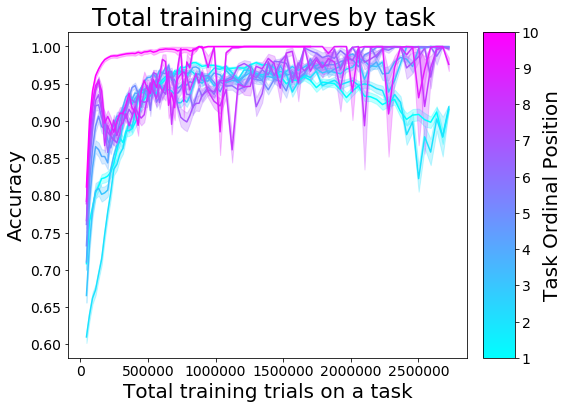

In [9]:
raw_data = baseline_total_curve_analyses.combined.raw
small_bins = (np.arange(40) + 1) * 22500
large_bins = ((np.arange(40) + 1) * 44500) + small_bins[-1]
bins = np.hstack((small_bins, large_bins))
plot_total_task_curves(raw_data, bins, last_bin_inc=45000)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


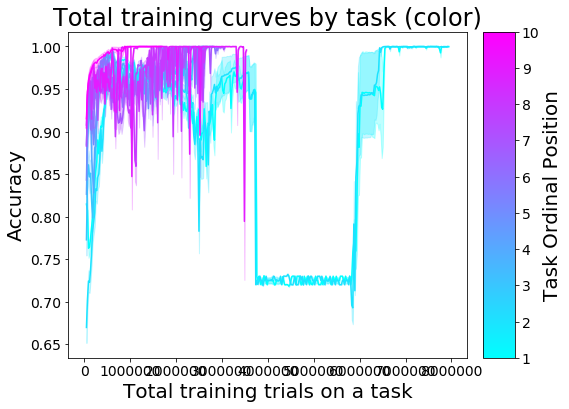

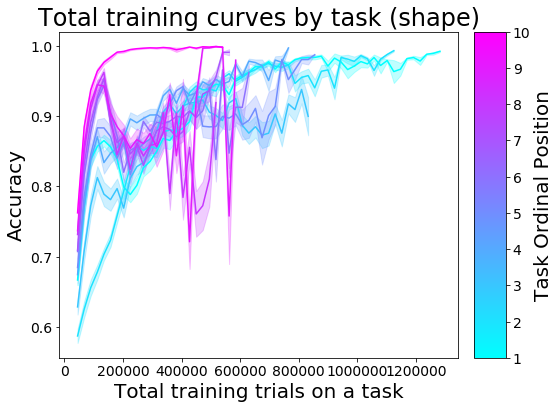

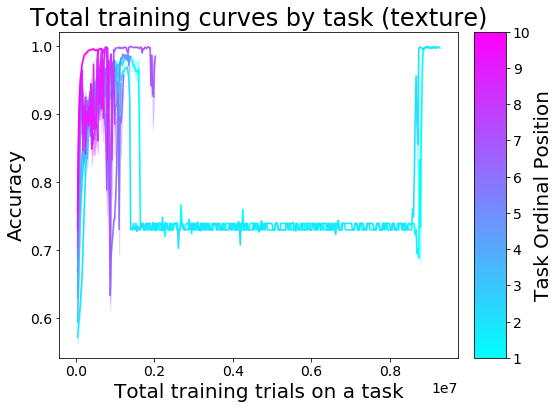

In [10]:
for dimension_id in range(3):
    raw_data = baseline_total_curve_analyses[dimension_id].raw
    max_data = max([max(raw_data[t].keys()) for t in raw_data.keys()])
    max_bin = max_data // 22500
    bins = (np.arange(max_bin) + 1) * 22500
    
    plot_total_task_curves(raw_data, bins, last_bin_inc=22500, custom_title=f'({analysis.DIMENSION_NAMES[dimension_id]})')

------

# Combine tasks 1-2, 3-10

In [17]:
def plot_total_task_curves_combined(raw_data, bins, num_tasks=10, last_bin_inc=22500, custom_title=''):
    new_task_colormap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)
    first_task_colormap = plt.get_cmap(NUM_TIMES_TRAINED_COLORMAP)

    fig, ax = plt.subplots(figsize=(8, 6))
    
    first_two_tasks = merge_dicts((raw_data[1], raw_data[2]))
    other_tasks = merge_dicts([raw_data[i] for i in range(3, 11)])

    for task_data, color_index, label in zip((first_two_tasks, other_tasks),
                                             (1, 6), ('First two', 'Last eight')):
        indices = np.digitize(list(task_data.keys()), bins)
        
        binned_x = [list() for _ in range(len(bins) + 1)]
        binned_y = [list() for _ in range(len(bins) + 1)]
        
        for idx, (num_trials, accuracies) in zip(indices, task_data.items()):
            binned_x[idx].append(num_trials)
            binned_y[idx].extend(accuracies)
            
        x = list(bins) + [bins[-1] + last_bin_inc]
        y_mean = np.array([np.nanmean(bin_slot) for bin_slot in binned_y])
        y_sem = np.array([np.nanstd(bin_slot) / np.sqrt(len(bin_slot)) for bin_slot in binned_y])
        
        color = new_task_colormap((color_index - 1) / (num_tasks - 1))

        plt.plot(x, y_mean, color=color, label=label) 
        plt.fill_between(x, y_mean - y_sem, y_mean + y_sem, color=color, alpha=0.25)
    
    # plt.xticks(bins)
    # plt.xlim(xticks[0], xticks[-1])

#     plots.add_colorbar_to_axes(ax, new_task_colormap, vmin=1, vmax=num_tasks, 
#                                y_label='Task Ordinal Position', y_label_font_dict=FONT_DICT,
#                                y_label_right=True)

    ax.set_xlabel('Total training trials on a task', **FONT_DICT)
    ax.set_ylabel('Accuracy', **FONT_DICT)
    ax.set_title(f'Total training curves by task {custom_title}', **TITLE_FONT_DICT)
    plt.legend(loc='best', **FONT_DICT)
    plt.show()
    
    
def merge_dicts(dicts):
    merged = copy.deepcopy(dicts[0])
    
    for d in dicts[1:]:
        for key in d:
            if key in merged:
                merged[key].extend(d[key])
            else:
                merged[key] = d[key]
                
    return merged

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


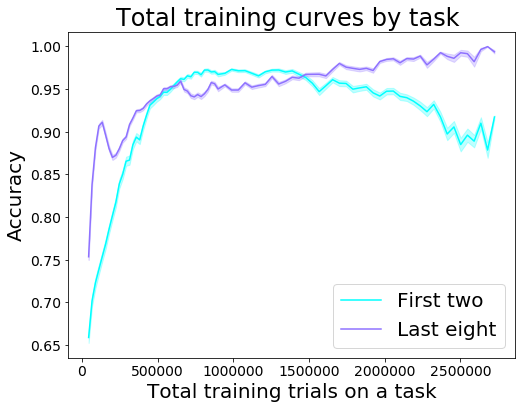

In [18]:
raw_data = baseline_total_curve_analyses.combined.raw
small_bins = (np.arange(40) + 1) * 22500
large_bins = ((np.arange(40) + 1) * 44500) + small_bins[-1]
bins = np.hstack((small_bins, large_bins))
plot_total_task_curves_combined(raw_data, bins, last_bin_inc=45000)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


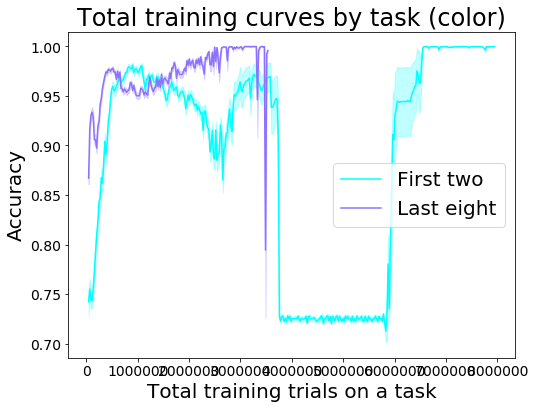

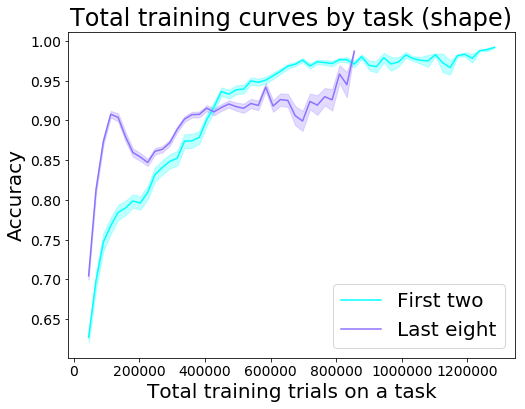

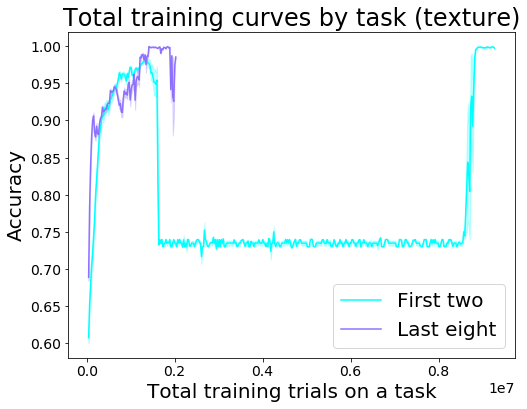

In [19]:
for dimension_id in range(3):
    raw_data = baseline_total_curve_analyses[dimension_id].raw
    max_data = max([max(raw_data[t].keys()) for t in raw_data.keys()])
    max_bin = max_data // 22500
    bins = (np.arange(max_bin) + 1) * 22500
    
    plot_total_task_curves_combined(raw_data, bins, last_bin_inc=22500, custom_title=f'({analysis.DIMENSION_NAMES[dimension_id]})')